## Data input note

Project 3 reads a **monthly sign-ups time series CSV** exported from the Sphere/Airtable reporting workflow. If you move this notebook into a repo, keep the CSV in a `data/` folder and update the file path in the load step if needed.

# **📚 Overall Project Proposal**
## Data Integrity in Action: Pre-processing Young People’s Records for Smarter Insights

From Data Chaos to Data-Driven Insights- This portfolio will present three interconnected projects that together form a phased, progressive, integrated, end-to-end data pipeline: (1) establishing a reliable data foundation, (2) enabling visual storytelling for stakeholders, and (3) piloting predictive/prescriptive approaches to personalise future programming.

Across all phases, the portfolio will demonstrate a full pipeline from raw data to actionable insights as well as my ability to handle real-world data challenges, build effective analytics workflows, and translate insights into meaningful organisational value.

## 🎨 Setup

In [1]:
#Set up the environment
import pandas as pd #Load the dataset from data/SSphere.csv into a DataFrame- used to "tidy" up and manipulate our data

import numpy as np #To use later for stats analysis- used for matrix and numerical calculations; foundation of pandas

import itertools

from scipy import stats #contains stats functions and is used to visualise probability distributions

import matplotlib.pyplot as plt #used for visualisations
%matplotlib inline

import matplotlib as mpl
from matplotlib import font_manager
from matplotlib.axes._axes import _log as matplotlib_axes_logger # Suppress Matplotlib specific warnings except errors
matplotlib_axes_logger.setLevel('ERROR')
import warnings
warnings.filterwarnings('ignore') # Suppressing all other general warnings except errors

import seaborn as sns #more user-friendly library used for visualisations
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# time-series (optional)
from statsmodels.tsa.holtwinters import ExponentialSmoothing

**Note:** This notebook assumes you have already generated the cleaned/enriched datasets from **Projects 1–2** (e.g., `Att_v3`, `Att_v4`, `Fb_new`) or have loaded equivalent exports from your processed data. If you run this notebook standalone, add a data-loading cell here to read in the Projects 1–2 output CSV(s).

# **3️⃣ Project 3:**
## Predicting & Modelling Retention: Forecasting Return Cycles & Re-Engaging Participants at the Right Time

Project 3 explores predictive and prescriptive analytics to prototype early models that can inform future engagement strategies and generate prescriptive recommendations for when and how to re-engage participants. Instead of full behavioural prediction—which is currently limited by the absence of baseline scores—this phase focuses on analysing the time interval between a participant’s first sign-up and their most recent event, treating it as a proxy for engagement continuity. By identifying trends, patterns, and optimal windows for re-engagement, this project provides evidence-based recommendations for when to invite participants back, supporting retention and programme effectiveness. This phase also outlines how Stemettes could build a next-best-action recommendation system in the future, using demographic data, attendance patterns, and engagement history to guide participants toward the most relevant opportunities.

Across all phases, the portfolio will demonstrate a full pipeline from raw data to actionable insights as well as my ability to handle real-world data challenges, build effective analytics workflows, and translate insights into meaningful organisational value.

In [92]:
#Project 3: Time Series Analysis & Forecasting of Monthly Sign-ups

#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import STL

#For simple regression-based forecasting
import statsmodels.api as sm

In [112]:
#1. Load Data & Convert to Monthly
df_daily = pd.read_csv("monthly_signups.csv")

#Convert date column to datetime and sort
#df_daily["date"] = pd.to_datetime(df_daily["date"])
df_daily["date"] = pd.to_datetime(df_daily["date"],
    format="%d/%m/%Y"   # ⭐
)

df_daily = df_daily.sort_values("date")
df_daily.set_index("date", inplace=True)


print("Daily data loaded:")
print(df_daily.head())
print("\nDaily data info:")
print(df_daily.info())


#Dataset is already aggregated at monthly level (validated via date structure); no resampling required
df_monthly = df_daily.copy()

#Optional
#Sanity Checks
print(df_monthly["total_signups"].describe())
print(df_monthly.index.to_series().diff().value_counts())

#check basic stats
print("\nMonthly summary statistics:")
print(df_monthly.describe())

print("\nMonthly missing values:")
print(df_monthly.isna().sum())

Daily data loaded:
            total_signups  new_signups  existing_signups  signups_5_11  signups_12_15  signups_16_25  signups_unknown_age  num_open_events  num_hack_events  num_panel_events  \
date                                                                                                                                                                            
2023-01-01            190          139                51             0              2             93                   95                3                1                 0   
2023-02-01            186          103                83            14             23             63                   86                1                0                 1   
2023-03-01              0            0                 0             0              0              0                    0                2                1                 1   
2023-04-01            245          133               112            33             65           

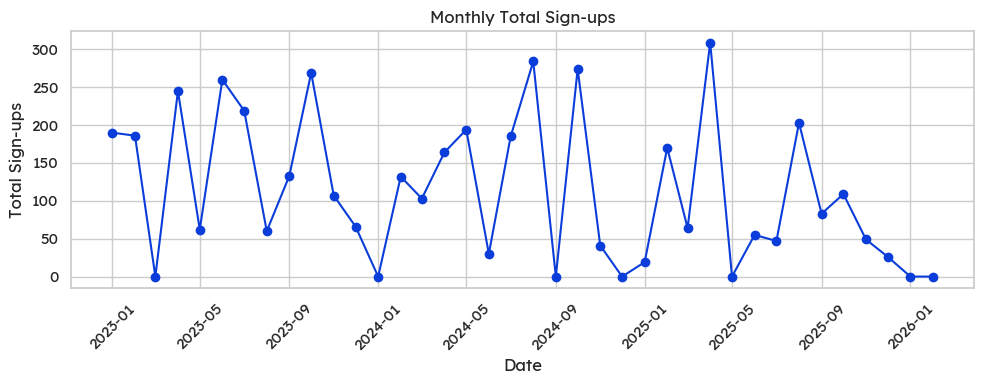

In [113]:
#2. Visualise Main Time Series

plt.figure(figsize=(10,4))
plt.plot(df_monthly.index, df_monthly["total_signups"], marker="o")
plt.title("Monthly Total Sign-ups")
plt.xlabel("Date")
plt.ylabel("Total Sign-ups")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

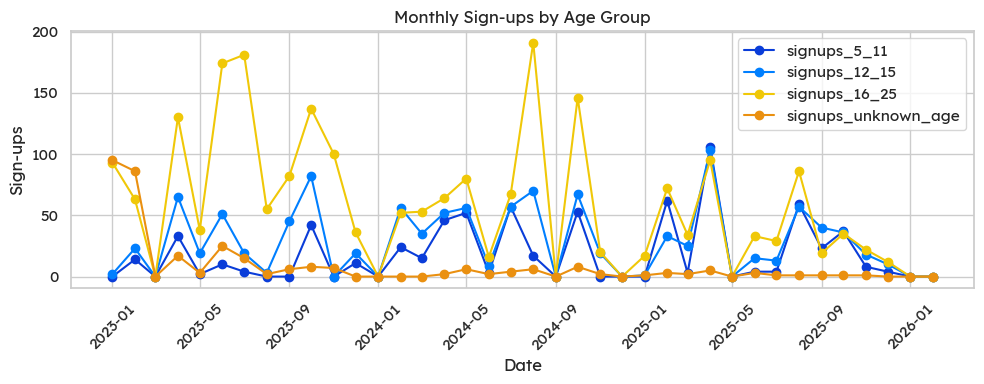

In [97]:
#Optional: Visualise age-group sign-ups over time
age_cols = ["signups_5_11", "signups_12_15", "signups_16_25", "signups_unknown_age"]

plt.figure(figsize=(10,4))
for col in age_cols:
    if col in df_monthly.columns:
        plt.plot(df_monthly.index, df_monthly[col], marker="o", label=col)
plt.title("Monthly Sign-ups by Age Group")
plt.xlabel("Date")
plt.ylabel("Sign-ups")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

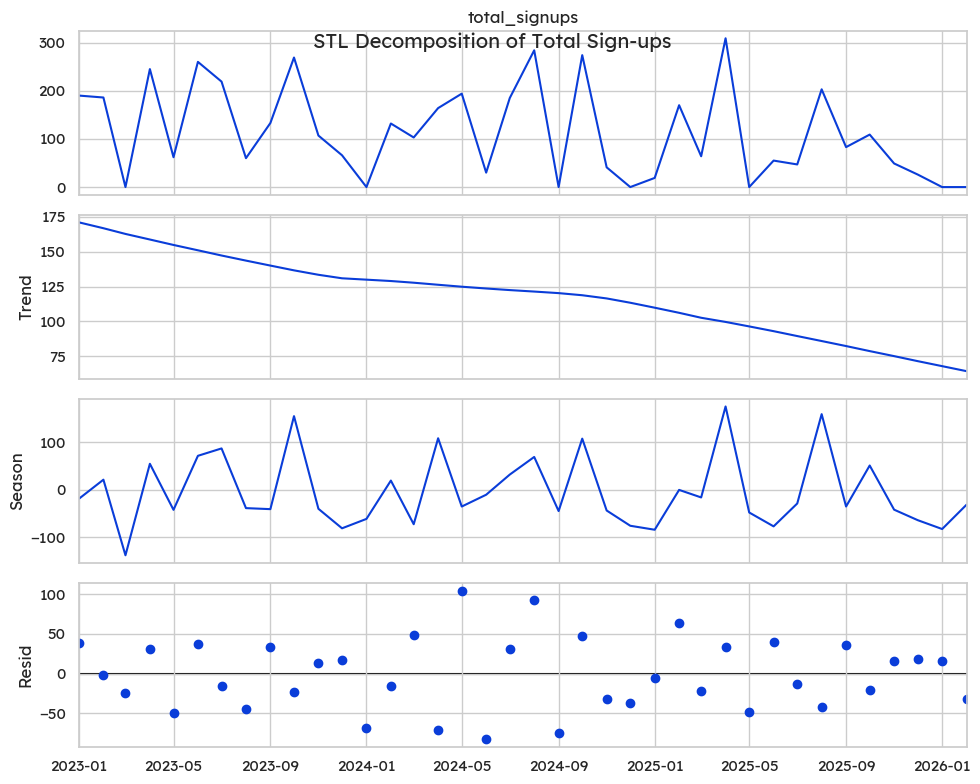

In [98]:
#3.Time Series Decomposition (Trend, Seasonality, Residual)

#Drop NaNs for decomposition if needed
ts = pd.to_numeric(df_monthly["total_signups"], errors="coerce").dropna()

stl = STL(ts, period=12)  # 12 for yearly seasonality if monthly data
result = stl.fit()

plt.rcParams['figure.figsize'] = [10, 8]
result.plot()
plt.suptitle("STL Decomposition of Total Sign-ups", y=0.95)
plt.show()


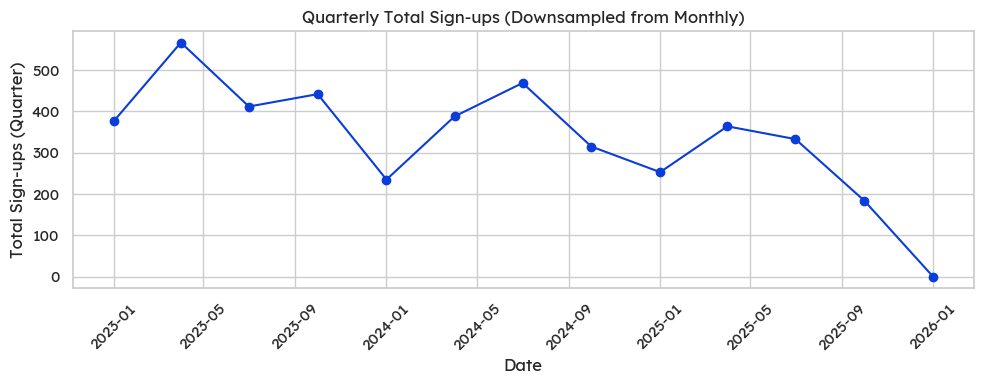

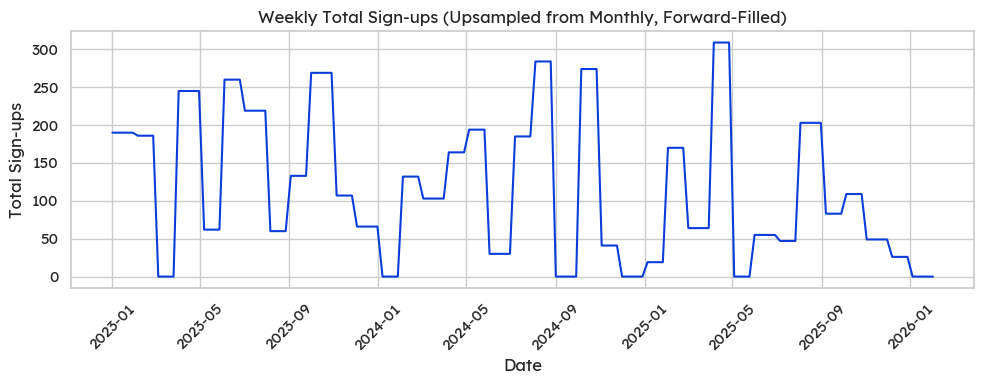

In [114]:
#4. Resampling Examples (Based on Monthly Data)

# Downsample to quarterly by summing sign-ups per quarter
# QS = quarter start (cleaner labels for stakeholders)
df_quarterly = df_monthly["total_signups"].resample("QS").sum()

plt.figure(figsize=(10,4))
plt.plot(df_quarterly.index, df_quarterly.values, marker="o")
plt.title("Quarterly Total Sign-ups (Downsampled from Monthly)")
plt.xlabel("Date")
plt.ylabel("Total Sign-ups (Quarter)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Upsample monthly series to weekly with forward-fill (illustrative)
df_weekly = df_monthly["total_signups"].resample("W").ffill()

plt.figure(figsize=(10,4))
plt.plot(df_weekly.index, df_weekly.values)
plt.title("Weekly Total Sign-ups (Upsampled from Monthly, Forward-Filled)")
plt.xlabel("Date")
plt.ylabel("Total Sign-ups")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


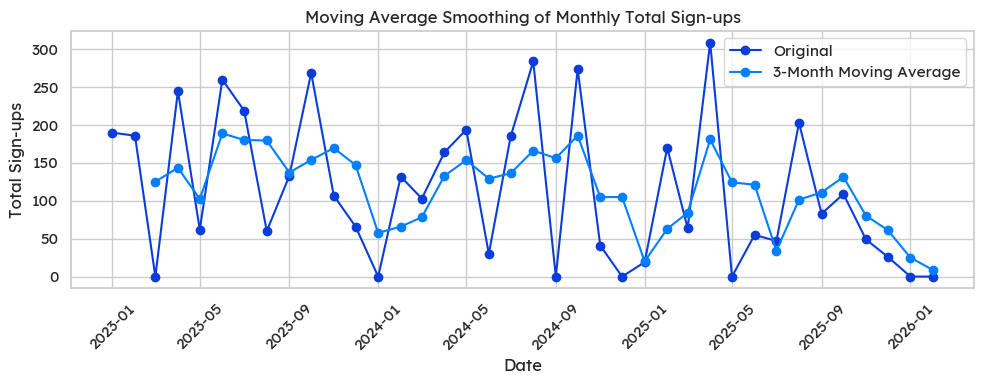

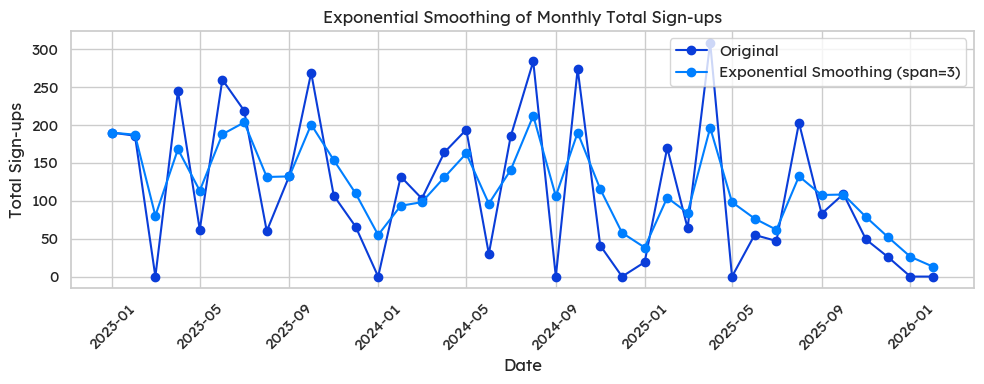

In [100]:
#5.Smoothing: Moving Average & Exponential Smoothing

#3-month moving average
rolling_mean_3 = df_monthly["total_signups"].rolling(window=3).mean()

plt.figure(figsize=(10,4))
plt.plot(df_monthly.index, df_monthly["total_signups"], marker="o", label="Original")
plt.plot(df_monthly.index, rolling_mean_3, marker="o", label="3-Month Moving Average")
plt.title("Moving Average Smoothing of Monthly Total Sign-ups")
plt.xlabel("Date")
plt.ylabel("Total Sign-ups")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Exponential smoothing (span=3)
exp_smooth = df_monthly["total_signups"].ewm(span=3).mean()

plt.figure(figsize=(10,4))
plt.plot(df_monthly.index, df_monthly["total_signups"], marker="o", label="Original")
plt.plot(df_monthly.index, exp_smooth, marker="o", label="Exponential Smoothing (span=3)")
plt.title("Exponential Smoothing of Monthly Total Sign-ups")
plt.xlabel("Date")
plt.ylabel("Total Sign-ups")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Correlation matrix (monthly):
                             total_signups  new_signups  existing_signups  signups_5_11  signups_12_15  signups_16_25  signups_unknown_age  num_open_events  num_hack_events  num_panel_events  \
total_signups                     1.000000     0.985107          0.957223      0.689502       0.851329       0.904041             0.348075         0.087767        -0.036995          0.105321   
new_signups                       0.985107     1.000000          0.893216      0.631532       0.818353       0.920629             0.348894         0.080229        -0.015803          0.121338   
existing_signups                  0.957223     0.893216          1.000000      0.740281       0.849070       0.814797             0.323085         0.094499        -0.070148          0.071223   
signups_5_11                      0.689502     0.631532          0.740281      1.000000       0.817942       0.379405            -0.066845         0.014616        -0.105821          0.137010   

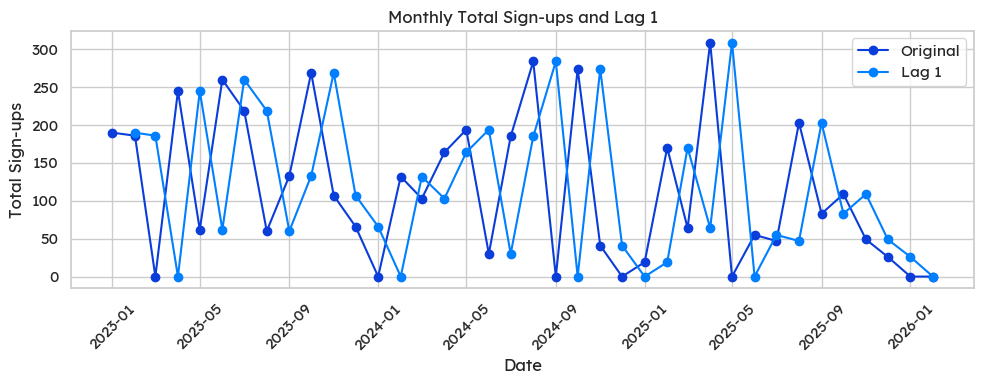

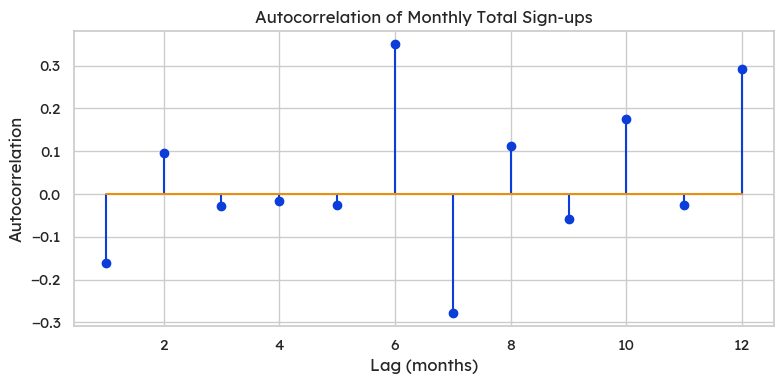


Autocorrelations (lags 1–12):
Lag 1: -0.160
Lag 2: 0.096
Lag 3: -0.028
Lag 4: -0.016
Lag 5: -0.025
Lag 6: 0.350
Lag 7: -0.277
Lag 8: 0.111
Lag 9: -0.058
Lag 10: 0.175
Lag 11: -0.027
Lag 12: 0.293


In [115]:
#6. Correlation, Lag Features, Autocorrelation

# Correlation matrix including age groups and events
corr_cols = [
    "total_signups",
    "new_signups",
    "existing_signups",
    "signups_5_11",
    "signups_12_15",
    "signups_16_25",
    "signups_unknown_age",
    "num_open_events",
    "num_hack_events",
    "num_panel_events",
    "num_leadership_academies",
    "num_certification_academies",
    "num_explore_events",
]

# Keep only columns that actually exist in df_monthly
corr_cols = [c for c in corr_cols if c in df_monthly.columns]

corr_df = df_monthly[corr_cols].dropna()
corr_matrix = corr_df.corr()

print("\nCorrelation matrix (monthly):")
print(corr_matrix)

# ---- Create a separate feature dataframe for lag/ACF plots (keeps df_monthly clean) ----
df_feat = df_monthly[["total_signups"]].copy()
df_feat["total_signups_lag1"] = df_feat["total_signups"].shift(1)

plt.figure(figsize=(10,4))
plt.plot(df_feat.index, df_feat["total_signups"], marker="o", label="Original")
plt.plot(df_feat.index, df_feat["total_signups_lag1"], marker="o", label="Lag 1")
plt.title("Monthly Total Sign-ups and Lag 1")
plt.xlabel("Date")
plt.ylabel("Total Sign-ups")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Autocorrelation for lags 1–12
ts_monthly = df_feat["total_signups"].dropna()
lags = range(1, 13)
autocorrs = [ts_monthly.autocorr(lag=lag) for lag in lags]

plt.figure(figsize=(8,4))
plt.stem(lags, autocorrs, use_line_collection=True)
plt.xlabel("Lag (months)")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation of Monthly Total Sign-ups")
plt.tight_layout()
plt.show()

print("\nAutocorrelations (lags 1–12):")
for lag, ac in zip(lags, autocorrs):
    print(f"Lag {lag}: {ac:.3f}")


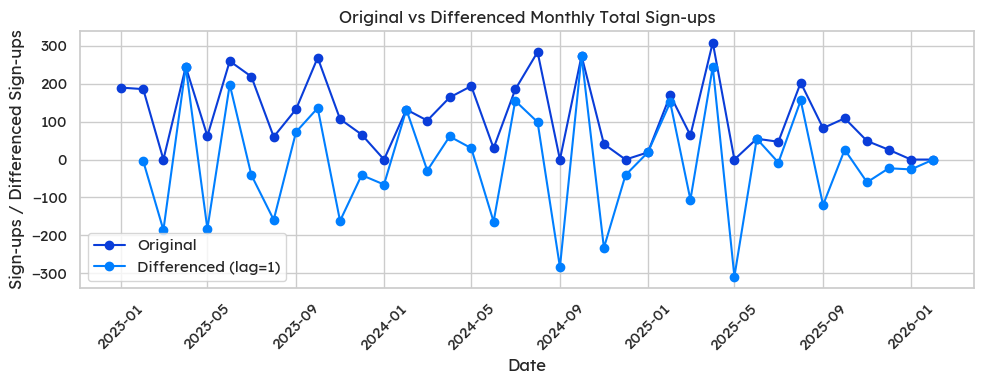

In [116]:
#7. Stationarity Approximation Via Differencing

# Use df_feat from Step 6 (or recreate it if running Step 7 independently)
if "df_feat" not in globals():
    df_feat = df_monthly[["total_signups"]].copy()

df_feat["total_signups_diff1"] = df_feat["total_signups"].diff(1)

plt.figure(figsize=(10,4))
plt.plot(df_feat.index, df_feat["total_signups"], marker="o", label="Original")
plt.plot(df_feat.index, df_feat["total_signups_diff1"], marker="o", label="Differenced (lag=1)")
plt.title("Original vs Differenced Monthly Total Sign-ups")
plt.xlabel("Date")
plt.ylabel("Sign-ups / Differenced Sign-ups")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Train period: 2023-01-01 to 2025-08-01
Test period:  2025-09-01 to 2026-02-01
Train rows: 32 | Test rows: 6

Regression model summary:
                            OLS Regression Results                            
Dep. Variable:          total_signups   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     2.003
Date:                Thu, 22 Jan 2026   Prob (F-statistic):             0.0851
Time:                        07:15:00   Log-Likelihood:                -178.77
No. Observations:                  32   AIC:                             383.5
Df Residuals:                      19   BIC:                             402.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.

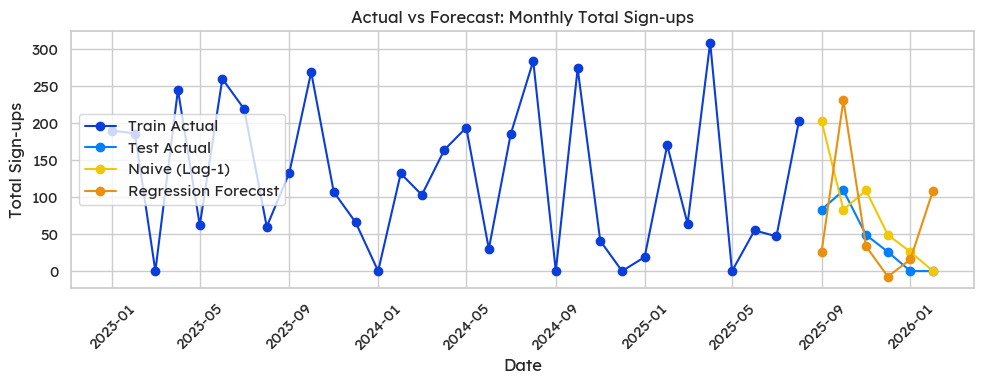


Seasonality used in regression model? True


In [103]:
#8. Simple Forecasting Model (Naive Vs Regression Model)

# Use only rows where total_signups is not NaN
model_df = df_monthly[["total_signups"]].dropna().copy()

# Add numeric time index for trend
model_df["t"] = np.arange(1, len(model_df) + 1)

# Add month number for seasonality
model_df["month"] = model_df.index.month.astype(int)

# --- Train/Test split (robust) ---
test_size = 6
if len(model_df) <= test_size:
    test_size = max(1, len(model_df)//3)  # auto-adjust if short series

train = model_df.iloc[:-test_size].copy()
test  = model_df.iloc[-test_size:].copy()

print("\nTrain period:", train.index.min().date(), "to", train.index.max().date())
print("Test period: ", test.index.min().date(), "to", test.index.max().date())
print("Train rows:", len(train), "| Test rows:", len(test))

# --- Baseline: naive forecast (lag-1 / previous month) ---
test["naive_forecast"] = model_df["total_signups"].shift(1).loc[test.index]

# Drop rows where naive forecast isn't available (can happen at series start)
test = test.dropna(subset=["naive_forecast"])

y_train = train["total_signups"].astype(float)
y_test  = test["total_signups"].astype(float)

# --- Regression design matrix: trend + (optional) seasonality ---
min_obs_for_seasonality = 18  # rule of thumb: at least 1.5 years of monthly data
use_seasonality = len(train) >= min_obs_for_seasonality

if use_seasonality:
    X_train = pd.get_dummies(train[["t", "month"]], columns=["month"], drop_first=True).astype(float)
    X_test  = pd.get_dummies(test[["t", "month"]],  columns=["month"], drop_first=True).astype(float)
else:
    X_train = train[["t"]].astype(float)
    X_test  = test[["t"]].astype(float)

# Add intercept and align columns so predict never breaks
X_train = sm.add_constant(X_train, has_constant="add")
X_test  = sm.add_constant(X_test,  has_constant="add")
X_test  = X_test.reindex(columns=X_train.columns, fill_value=0)

# Fit regression model
reg_model = sm.OLS(y_train, X_train).fit()
print("\nRegression model summary:")
print(reg_model.summary())

# Predict
test["reg_forecast"] = reg_model.predict(X_test)

# --- RMSE evaluation ---
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

rmse_naive = rmse(y_test, test["naive_forecast"])
rmse_reg   = rmse(y_test, test["reg_forecast"])

print(f"\nRMSE - Naive (lag-1):    {rmse_naive:.2f}")
print(f"RMSE - Regression model: {rmse_reg:.2f}")

# --- Plot actual vs forecast on monthly data ---
plt.figure(figsize=(10,4))
plt.plot(train.index, train["total_signups"], marker="o", label="Train Actual")
plt.plot(test.index, test["total_signups"], marker="o", label="Test Actual")
plt.plot(test.index, test["naive_forecast"], marker="o", label="Naive (Lag-1)")
plt.plot(test.index, test["reg_forecast"], marker="o", label="Regression Forecast")
plt.title("Actual vs Forecast: Monthly Total Sign-ups")
plt.xlabel("Date")
plt.ylabel("Total Sign-ups")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nSeasonality used in regression model?" , use_seasonality)


In [104]:
print(df_monthly.index.min(), df_monthly.index.max(), len(df_monthly))
print(df_monthly["total_signups"].notna().sum())
print(df_monthly.head(12)[["total_signups"]])
print(df_monthly.tail(12)[["total_signups"]])


2023-01-01 00:00:00 2026-02-01 00:00:00 38
38
            total_signups
date                     
2023-01-01            190
2023-02-01            186
2023-03-01              0
2023-04-01            245
2023-05-01             62
2023-06-01            260
2023-07-01            219
2023-08-01             60
2023-09-01            133
2023-10-01            269
2023-11-01            107
2023-12-01             66
            total_signups
date                     
2025-03-01             64
2025-04-01            309
2025-05-01              0
2025-06-01             55
2025-07-01             47
2025-08-01            203
2025-09-01             83
2025-10-01            109
2025-11-01             49
2025-12-01             26
2026-01-01              0
2026-02-01              0



Future monthly forecast (next months):
            reg_forecast
2026-03-01     11.287037
2026-04-01    185.444444
2026-05-01     31.444444
2026-06-01     61.111111
2026-07-01     96.444444
2026-08-01    128.444444


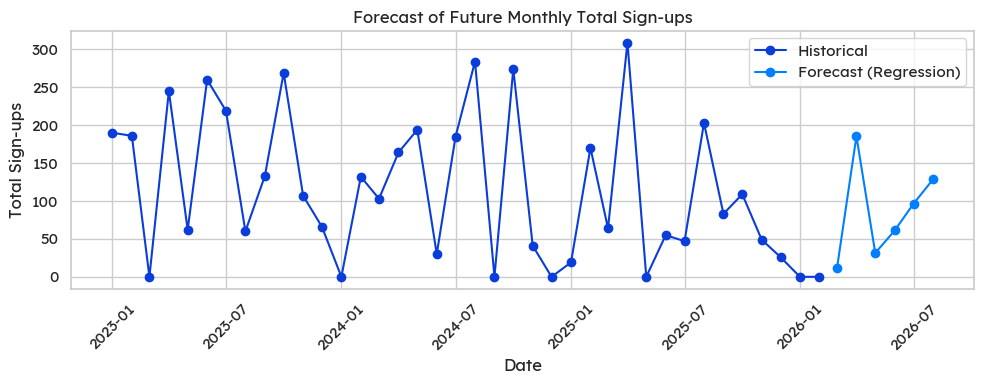

In [117]:
#9. Forecast Future Months (Regression Model)

N_future = 6  # number of months to forecast

last_date = model_df.index.max()
future_index = pd.date_range(
    start=last_date + pd.offsets.MonthBegin(1),
    periods=N_future,
    freq="MS"
)

future_df = pd.DataFrame(index=future_index)
future_df["t"] = np.arange(model_df["t"].max() + 1, model_df["t"].max() + 1 + N_future)
future_df["month"] = future_df.index.month.astype(int)

# Build future design matrix to match training columns exactly
if use_seasonality:
    X_future = pd.get_dummies(
        future_df[["t", "month"]],
        columns=["month"],
        drop_first=True
    ).astype(float)
else:
    X_future = future_df[["t"]].astype(float)

X_future = sm.add_constant(X_future, has_constant="add")

# Align to X_train columns (includes const + any month dummies)
X_future = X_future.reindex(columns=X_train.columns, fill_value=0)

future_df["reg_forecast"] = reg_model.predict(X_future)

print("\nFuture monthly forecast (next months):")
print(future_df[["reg_forecast"]])

plt.figure(figsize=(10,4))
plt.plot(model_df.index, model_df["total_signups"], marker="o", label="Historical")
plt.plot(future_df.index, future_df["reg_forecast"], marker="o", label="Forecast (Regression)")
plt.title("Forecast of Future Monthly Total Sign-ups")
plt.xlabel("Date")
plt.ylabel("Total Sign-ups")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [106]:
df_daily.groupby(df_daily.index.day).sum()["total_signups"].sort_values(ascending=False)

date
1    4338
Name: total_signups, dtype: int64

The above visualisation shows monthly time series data of Stemettes Sign-up/BOSS totals (in hundreds) spanning from January 2003 to December 2005. It captures the historical trends and variations in sign-up/attendance numbers over this period, allowing for analysis of seasonal patterns, overall growth, and other insights related to engagement during that time frame. This data is valuable for forecasting future attendance, understanding historical patterns, and making informed decisions in the STEAM education industry.

In [107]:
# (5.2) Get a numbered index list of all unique values in main table > (df) 'field_name' column to decide on columns of interest for later slicing/ grouping
#for i, col in enumerate(df.columns):
#    print(f"{i}: {col}")

for i, col in enumerate(df.columns):
    print(f"{i}: {col} ({df[col].dtype})")

0: Record_ID (Feedback) (object)
1: Event (object)
2: Start Date (datetime64[ns])
3: Record_ID (Onb) (object)
4: t8 Stage (object)
5: Stream_1 (object)


AttributeError: 'DataFrame' object has no attribute 'dtype'

In [ ]:
# (5.3a) Define the t1 column rename mapping using indices to make grouping easier later
df_column_mapping = {
    df.columns[2]: "Record_ID",
    df.columns[12]: "first_att_type",
    df.columns[14]: "signup_date",
    df.columns[15]: "latest_event_date",
    df.columns[16]: "# Att",
    df.columns[31]: "Where did you hear about this event?",
    df.columns[34]: "Region", #Yorkshire and Vs And
    df.columns[39]: "Ethnic Background",
    df.columns[54]: "State-funded (%)",
    df.columns[40]: "FSM (%)",
    df.columns[32]: "Age Today",
    df.columns[38]: "Stream", # Stream based on Age today or Age on day of event?
    df.columns[64]: "P/G Attend Uni",
    df.columns[65]: "P/G Work in STEAM",
    df.columns[62]: "Pronouns",
}

# (5.3b) Apply the Main Table renaming to all four attendance tables
#t0 = t0.rename(columns=t0_column_mapping)
df1 = df.rename(columns=df_column_mapping)

# (5.3c) Get the list of new t1 column names (values from your mapping)
renamed_df_columns = list(df_column_mapping.values())

print("Renaming:", df_column_mapping)

In [ ]:
#Step 2: Convert the 'date' column (on Att_new4) into datetime format
#bikes['date'] = pd.to_datetime(bikes['date'])
df1["signup_date"] = pd.to_datetime(df1["signup_date"], errors="coerce")
df1["latest_event_date"] = pd.to_datetime(df1["latest_event_date"], errors="coerce")

df1.head(5)

In [ ]:
#Step 3: Set the 'dates' column as the index!!!!!!!!!!!!!!!!!!!!!!!!!
df1.set_index('signup_date', inplace=True)

#calculate retention duration in days
#df1["retention_days"] = (df1["latest_event_date"] - df1["signup_date"]).dt.days

#quick summary
#df1["retention_days"].describe()

In [ ]:
df1.head(5)

In [ ]:
#print(df1['signup_date'].dropna())

In [ ]:
df1.plot();

In [ ]:
#Plot a graph with just the `count` as the `y-axis`.
df1.plot(y='count', figsize=(12,3), fontsize=12);

In [ ]:
#downsampling - change frequency to Season? or star with 52 weeks, and change to months
#get averages for season or month

In [ ]:
from statsmodels.tsa.seasonal import STL
plt.rcParams['figure.figsize'] = [12,8]

# Perform seasonal decomposition
stl = STL(df1['count'])
result = stl.fit()
result.plot();

# To extract the trend, seasonal, and residual components
# trend = result.trend
# seasonal = result.seasonal
# residual = result.resid

In [ ]:
#Moving average for last 30 days
rolling_mean = df1['temperature'].rolling(window=30).mean()
rolling_mean

plt.figure(figsize=(12,3))
plt.plot(bikes['temperature'], label='temperature')
plt.plot(rolling_mean, label='smooth_trend')
plt.legend(fontsize=12);

In [ ]:
# GROUP BY PARTICIPANT
retention = (
    df1.groupby("Record_ID")
      .agg(
          first_signup=("signup_date", "min"),
          last_event=("latest_event_date", "max"),
          events_attended=("# Att", "count")
      )
      .reset_index()
)

# CALCULATE RETENTION DAYS
retention["retention_days"] = (
    retention["last_event"] - retention["first_signup"]
).dt.days

retention.head(50)

In [ ]:
# BASIC SUMMARY
print(retention["retention_days"].describe())

# HISTOGRAM OF RETENTION
plt.figure(figsize=(8,5))
retention["retention_days"].plot(kind="hist", bins=30)
plt.xlabel("Retention (days between first sign-up and latest event)")
plt.ylabel("Number of participants")
plt.title("Distribution of participant retention")
plt.tight_layout()
plt.show()


In [ ]:
# FLOOR first_signup to month start
retention["first_signup_month"] = retention["first_signup"].dt.to_period("M").dt.to_timestamp()

# AVERAGE RETENTION BY FIRST SIGNUP MONTH
monthly_retention = (
    retention.groupby("first_signup_month")["retention_days"]
             .mean()
             .reset_index()
             .rename(columns={"retention_days": "avg_retention_days"})
)

monthly_retention.head()


In [ ]:
plt.figure(figsize=(10,5))
plt.plot(monthly_retention["first_signup_month"],
         monthly_retention["avg_retention_days"],
         marker="o")
plt.xlabel("First signup month")
plt.ylabel("Average retention (days)")
plt.title("Average retention by signup month")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Only keep non-null averages
ts = monthly_retention.dropna(subset=["avg_retention_days"]).copy()

# Convert dates to an integer index (0,1,2,...)
ts["t"] = np.arange(len(ts))

X = ts["t"].values
y = ts["avg_retention_days"].values

# FIT A SIMPLE LINE: y = a * t + b
a, b = np.polyfit(X, y, 1)

print("Slope (a):", a)
print("Intercept (b):", b)

# MAKE A SMALL FORECAST FOR NEXT 3 MONTHS
n_forecast = 3
t_future = np.arange(len(ts), len(ts) + n_forecast)

y_future = a * t_future + b

# BUILD A FORECAST DATAFRAME
last_month = ts["first_signup_month"].max()
future_months = pd.date_range(last_month + pd.offsets.MonthBegin(1),
                              periods=n_forecast, freq="MS")

forecast_df = pd.DataFrame({
    "first_signup_month": future_months,
    "avg_retention_days_forecast": y_future
})

forecast_df


In [ ]:
plt.figure(figsize=(10,5))

# Actuals
plt.plot(ts["first_signup_month"],
         ts["avg_retention_days"],
         marker="o",
         label="Actual avg retention")

# Forecast
plt.plot(forecast_df["first_signup_month"],
         forecast_df["avg_retention_days_forecast"],
         marker="o",
         linestyle="--",
         label="Forecast avg retention")

plt.xlabel("First signup month")
plt.ylabel("Average retention (days)")
plt.title("Average retention by signup month – actuals and simple forecast")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Merge retention metrics back into original df (one row per event)
df_with_retention = df1.merge(
    retention[["Record_ID", "retention_days", "events_attended"]],
    on="Record_ID",
    how="left"
)

# Example: average retention by region
retention_by_region = (
    df_with_retention.groupby("Region")["retention_days"]
                     .mean()
                     .sort_values(ascending=False)
)

print(retention_by_region)


In [ ]:
# Basic Cleaning
# make dates real dates
stem["signup_date"] = pd.to_datetime(stem["signup_date"], errors="coerce")
stem["latest_event_date"] = pd.to_datetime(stem["latest_event_date"], errors="coerce")

# drop rows with missing critical dates
stem = stem.dropna(subset=["signup_date", "latest_event_date"])

# standardise region text to help joining
stem["region"] = stem["region"].str.strip().str.title()
pub["region"]  = pub["region"].str.strip().str.title()

In [ ]:
#Create “days_between” (time between first and latest event)
stem["days_between"] = (stem["latest_event_date"] - stem["signup_date"]).dt.days
stem["signup_month"] = stem["signup_date"].dt.to_period("M").dt.to_timestamp()
stem["latest_month"] = stem["latest_event_date"].dt.to_period("M").dt.to_timestamp()

stem["days_between"].describe()
stem.groupby("signup_month")["days_between"].mean().head()

In [ ]:
#Descriptive summaries
# overall time-between distribution
df["days_between"].plot(kind="hist", bins=30, title="Days between first and latest event")
plt.show()

# monthly averages
monthly = df.groupby("signup_month", as_index=False).agg(
    avg_days_between=("days_between","mean"),
    median_days_between=("days_between","median"),
    n=("participant_id","count")
)
monthly.head()

In [ ]:
plt.plot(monthly["signup_month"], monthly["avg_days_between"])
plt.title("Average days between events (by signup month)")
plt.xlabel("Month")
plt.ylabel("Avg days")
plt.show()

In [ ]:
#Simple time-series forecast
ts = monthly.set_index("signup_month")["avg_days_between"].asfreq("MS")  # monthly start
ts = ts.interpolate()  # fill tiny gaps if any

model = ExponentialSmoothing(ts, trend="add", seasonal=None)
fit = model.fit()
forecast = fit.forecast(3)  # next 3 months

ts.plot(label="history")
forecast.plot(label="forecast")
plt.legend(); plt.title("Avg days_between: 3-month forecast"); plt.show()

forecast


In [ ]:
#Turn “days_between” into simple invite windows (prescription)
q25, q50, q75 = np.percentile(df["days_between"], [25, 50, 75])
q25, q50, q75


In [ ]:
prescription = pd.DataFrame({
    "window": ["early", "standard", "late"],
    "days_threshold": [q25, q50, q75]
})
prescription


In [ ]:
#Build a simple predictive model
features = [
    "days_between",
    "fsm_percent",                  # or your exact FSM field
    "prior_attendance",             # 0/1 (if not numeric, map it)
    "girls_gcse_stem_share"         # from public data (rename to your real column)
]

# simple cleaning: coerce numeric, fill small gaps
for col in features:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df["prior_attendance"] = df["prior_attendance"].map({"Yes":1, "No":0}).fillna(0)

X = df[features].fillna(df[features].median())
y = df["confidence_ord"]


In [ ]:
#Train/test split & model
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

pred = clf.predict(X_test)
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))


In [ ]:
#Turn model into guidance (prescription)
def predict_confidence(days_between, fsm_percent, prior_attendance, girls_gcse_stem_share):
    row = pd.DataFrame([{
        "days_between": days_between,
        "fsm_percent": fsm_percent,
        "prior_attendance": prior_attendance,
        "girls_gcse_stem_share": girls_gcse_stem_share
    }])
    row = row.fillna(X.median())
    proba = clf.predict_proba(row)[0]
    pred  = clf.predict(row)[0]
    return pred, proba

# example: what if we invite at 45 days vs 100 days for the same participant profile?
for d in [45, 100]:
    pred, proba = predict_confidence(
        days_between=d,
        fsm_percent=30,
        prior_attendance=1,
        girls_gcse_stem_share=40
    )
    print(d, "days → predicted level:", pred, "| probs:", np.round(proba, 2))


In [ ]:
#Save your outputs (so you can show them or build a dashboard)
monthly.to_csv("out_monthly_engagement.csv", index=False)
prescription.to_csv("out_invite_windows.csv", index=False)


In [ ]:
#fb['Experience /10'].plot(kind='hist', bins=5);

In [ ]:
#fb['Experience /10'].value_counts(bins=5, sort=False)

In [ ]:
#fb.groupby(by=['EventName'])['Experience /10'].mean().sort_values(ascending=False) #The groupby() method is showing the mean value of each Event

In [ ]:
#fb.groupby(by=['EventName'])['Experience /10'].mean().sort_values(ascending=False).plot(kind='bar');

In [ ]:
#Record_ID(Unique)_column = t8.pop("URN") # Cut the 'Record_ID(Unique)' column from the dataframe
#t8["URN"] = Record_ID(Unique) # Move 'URN' column to the end

In [ ]:
fb_sel = fb[['URN', 'LA (name)', 'EstablishmentName', 'TypeOfEstablishment (name)', 'Street', 'Locality', 'Town', 'Postcode', 'StatutoryLowAge', 'StatutoryHighAge', 'EstablishmentTypeGroup (name)', 'PercentageFSM', 'FSM', 'LSOA (code)','OfstedRating (name)']] # Create a new DataFrame with just the selected columns

fb_sel.head() # Display the result

In [ ]:
#Cardinality = Main Table:DfE table (Many:One), duplicates in Table 1, no duplicates in Table 2 - Keep all data in the main, only match data in right
df_new4 = df_new3_df.merge(t6_matched_df, how="left", on="URN", indicator=True)
df_new4.head()

#df1 = pd.DataFrame(df_new3_df)
#df2 = pd.DataFrame(t6_sel_df)

#newdf = df1.merge(df2, how='left', on="URN", indicator=True)
#newdf

In [ ]:
#Notes for Later ------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#For categoric data:
#Use bar charts when you want to compare the frequency of categories.
#Use pie charts for simple, proportional representations.

In [ ]:
# host_neighbourhood = discrete nominal label. Will need to be encoded numerically, with either OneHotEncoder or LabelEncoder

In [ ]:
#t6.display(URN, EstablishmentName, TypeOfEstablishment (name), EstablishmentTypeGroup (name), LSOA (code), FSM)
# Create df_attended containing only ppts with attended ‘y’
# df1_copy1 = df1[df1['Event'] == '"Achieve, Engineer, Explore: NewDay Hack"'].copy()
# df1_copy1

In [ ]:
# df2 = pd.read_csv('Data/Table 2-Test.csv')
# df2.head()

In [ ]:
#Pie chart of Pronouns
#pronoun_counts = Att_v4['Which pronouns do you use? (from Contacts x Eligibility) (from Contacts x Preferences) (from Student Name)'].value_counts()
plt.pie(pronoun_counts, labels=pronoun_counts.index, autopct='%1.1f%%', startangle=140)
plt.figure(figsize=(6,6))

plt.title('Pronouns')
plt.axis('equal')
plt.show()

In [ ]:
#Example input variables – replace these with your own
data_list = [
    pronoun_counts,  # Chart 1
    pronoun_counts,  # Chart 2 – replace with another variable
    pronoun_counts,  # Chart 3 – replace with another variable
    pronoun_counts   # Chart 4 – replace with another variable
]

titles = [
    'Pronouns Distribution',
    'Ethnic Background',
    'New/Existing Stemette',
    'LSOA'
]

legend_titles = [
    'Pronouns',
    'Ethnic Background',
    'New/Existing Stemette',
    'LSOA'
]

#Set up subplot layout
fig, axes = plt.subplots(1, 4, figsize=(20, 6))  # 1 row, 4 columns

for i, ax in enumerate(axes):
    labels = data_list[i].index
    sizes = data_list[i].values
    colors = brand_colours

    wedges, _ = ax.pie(
        sizes,
        labels=None,
        startangle=140,
        colors=colors
    )

    # Donut hole
    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    ax.add_artist(centre_circle)

    # Legend below each chart
    ax.legend(
        wedges,
        labels,
        title=legend_titles[i],
        title_fontproperties={'weight': 'bold'},
        loc='upper center',
        bbox_to_anchor=(0.5, -0.15),
        ncol=2,
        frameon=True,
        fancybox=True
    )

    ax.set_title(titles[i], pad=15)
    ax.axis('equal')  # Equal aspect ratio for a perfect circle

plt.tight_layout()
plt.show()

In [ ]:
#Example input variables – replace these with your own
data_list = [
    pronoun_counts,  # Chart 1
    pronoun_counts,  # Chart 2 – replace with another variable
    pronoun_counts,  # Chart 3 – replace with another variable
    pronoun_counts   # Chart 4 – replace with another variable
]

titles = [
    'State School',
    'Positive Representation',
    'Access to Education',
    'FSM Eligibility'
]

legend_titles = [
    'School Type',
    'P/G Work in STEAM?',
    'P/G Attend Uni?',
    'Eligible for FSM?'
]

#Set up subplot layout
fig, axes = plt.subplots(1, 4, figsize=(20, 6))  # 1 row, 4 columns

for i, ax in enumerate(axes):
    labels = data_list[i].index
    sizes = data_list[i].values
    colors = brand_colours

    wedges, _ = ax.pie(
        sizes,
        labels=None,
        startangle=140,
        colors=colors
    )

    # Donut hole
    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    ax.add_artist(centre_circle)

    # Legend below each chart
    ax.legend(
        wedges,
        labels,
        title=legend_titles[i],
        title_fontproperties={'weight': 'bold'},
        loc='upper center',
        bbox_to_anchor=(0.5, -0.15),
        ncol=2,
        frameon=True,
        fancybox=True
    )

    ax.set_title(titles[i], pad=15)
    ax.axis('equal')  # Equal aspect ratio for a perfect circle

plt.tight_layout()
plt.show()

In [ ]:
# Get a numbered list of only float64 and int64 columns in fb
#for i, col in enumerate(fb.columns):
#    if fb[col].dtype in ['float64', 'int64']:
#        print(f"{i}: {col} ({fb[col].dtype})")

#numeric_cols = [(i, col, fb[col].dtype) for i, col in enumerate(fb.columns) if fb[col].dtype in ['float64', 'int64']]
#pd.DataFrame(numeric_cols, columns=['Index', 'Column', 'Dtype'])

In [ ]:
# Get a list of all unique values in 'field_name' column to decide on columns of interest
#col_values = t5['Field_Name'].unique()
#col_values

#Create a new DataFrame to help with mapping and decision-making
#col_map_df = pd.DataFrame({
#    'original_column_name': col_values,
#    'new_column_name': '',     # Add new name here if renaming
#    'keep_or_remove': ''      # Fill with 'keep' or 'remove'
#})

# Display it
#col_map_df

# Show only the rows marked as 'keep'
#kept_cols = col_map_df[col_map_df['keep_or_remove'].str.lower() == 'keep']

#kept_cols

In [ ]:
#t5 = pd.read_csv('Data/Table 2-fID.csv')
#t7 = pd.read_csv('Data/Table 4-UK-Region.csv')

In [ ]:
#Generate Summary Stats for Numerical Data
Att_v4.describe()
##Descriptive Stats for different time-periods, streams, regions, types... maybe boss- repeat this process for sign-ups

import matplotlib.colors as mcolors
from collections import defaultdict

def preview_subtype_palette(type_palette, df_typesub):
    """
    Generates a horizontal bar preview of lighter sub-type colours per Type.

    Parameters:
    - type_palette: dict mapping Type → brand colour (hex)
    - df_typesub: DataFrame with columns ['Type', 'Event Sub-Type']
    """

    # Function to create lighter shades
    def lighten_color(color, amount=0.5):
        try:
            c = mcolors.cnames[color]
        except:
            c = color
        c = mcolors.to_rgb(c)
        return mcolors.to_hex([min(1, 1 - (1 - x) * amount) for x in c])

    subtype_counter = defaultdict(int)
    shade_mapping = {}

    for _, row in df_typesub.iterrows():
        type_name = row['Type']
        sub_type = row['Event Sub-Type']
        base_color = type_palette.get(type_name, "#cccccc")
        count = subtype_counter[type_name]
        lighter_shade = lighten_color(base_color, amount=0.6 + count * 0.1)
        shade_mapping[(type_name, sub_type)] = lighter_shade
        subtype_counter[type_name] += 1

    # Plot preview
    fig, ax = plt.subplots(figsize=(10, len(shade_mapping) * 0.4))
    y_pos = list(range(len(shade_mapping)))

    for i, ((type_name, sub_type), color) in enumerate(shade_mapping.items()):
        ax.barh(i, 1, color=color)
        ax.text(1.05, i, f"{type_name} → {sub_type}", va='center', fontsize=9)

    ax.set_yticks([])
    ax.set_xlim(0, 1.5)
    ax.set_title("Sub-Type Colour Shades by Type", fontsize=14, fontweight='bold')
    ax.axis('off')
    plt.tight_layout()
    plt.show()

    return shade_mapping  # optional: returns the mapping for use in plots
    
#Your brand colours per Type
type_palette = {
    'Type A': '#0a3dd9',
    'Type B': '#007fff',
    'Type C': '#f0c808',
    'Type D': '#ea9010',
    # add more if needed
}

#Get unique Type/Sub-Type pairs from your real DataFrame
#df_typesub = Att_v4[['Type', 'Event Sub-Type']].drop_duplicates()

#Preview palette and get mapping
#shade_mapping = preview_subtype_palette(type_palette, df_typesub)

#Setting the custom brand colours/fonts as default theme for Seaborn plots (save it in a theme.py and import it into each project)
brand_colours = ["#0a3dd9", "#007fff", "#f0c808", "#ea9010", "#61e294", "#8377d1"] #HEX:Cobalt Blue, Azure Blue, AU Yellow, Python green, HTML purple.
sns.set_theme(
    style="whitegrid",
    palette=brand_colors,
    font='League Spartan')
sns.palplot(sns.color_palette())
plt.title("Stemettes Brand Colour Palette")
plt.show()

In [ ]:
#Build a DataFrame showing old name vs new name (all potential slicers)
t1_rename_comparison = pd.DataFrame({
    "Original Name": list(t1_column_mapping.keys()),
    "Renamed Name": list(t1_column_mapping.values())
})
t6_rename_comparison = pd.DataFrame({
    "Original Name": list(t6_column_mapping.keys()),
    "Renamed Name": list(t6_column_mapping.values())
})

side_by_side = pd.concat([t1_rename_comparison, t6_rename_comparison], axis=1)
side_by_side.columns = ['T1 Original', 'T1 Renamed', 'T6 Original', 'T6 Renamed']

side_by_side

from IPython.display import display, HTML

display(HTML(f"""
    <div style="display: flex; gap: 40px;">
        <div style="flex: 1;">
            <h3>T1 Column Mapping</h3>
            {t1_rename_comparison.to_html(index=False)}
        </div>
        <div style="flex: 1;">
            <h3>T6 Column Mapping</h3>
            {t6_rename_comparison.to_html(index=False)}
        </div>
    </div>
"""))

In [ ]:
#Choose one pivot to plot
pivot_region = Att_v4_pivot1.copy()   # Region x Stream

#Ensure the index column is the first col after reset_index()
index_col = pivot_region.columns[0]
value_cols = list(pivot_region.columns[1:])

#Reorder columns: A–Z, but keep 'Outside UK' and 'Total' at the end (if present)
tail = [c for c in ["Outside the UK", "Total"] if c in value_cols]
head = sorted([c for c in value_cols if c not in tail])
ordered_cols = head + tail

# Optional: sort rows by index for nicer x-axis
#pivot_df = pivot_df.sort_values(by=index_col)

#Build grouped bars
x = np.arange(len(pivot_region))                     # positions for groups
n_series = len(ordered_cols)
bar_width = max(0.1, min(0.8 / n_series, 0.2))   # keep bars readable

#Color cycle (uses your brand palette, extend/cycle if needed)
color_cycle = itertools.cycle(brand_colours)

plt.figure(figsize=(12, 6))

for i, col in enumerate(ordered_cols):
    offsets = x + (i - (n_series-1)/2) * bar_width  # center the groups
    plt.bar(
        offsets,
        pivot_region[col].values,
        width=bar_width,
        label=col,
        color=next(color_cycle)
    )

plt.title("Regional Attendance by Stream (Side-by-Side)", fontname=fonts["headers"])
plt.xlabel(index_col)
plt.ylabel("Count")
plt.xticks(x, pivot_region[index_col], rotation=45, ha="right")
plt.legend(title="Stream", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)
plt.tight_layout()
plt.show()

In [ ]:
# Plot Region x Stream: bars = counts, thin outline = uniques
# --- Plot Region x Stream WITHOUT totals (column & row) ---
import numpy as np, itertools
import matplotlib.pyplot as plt
#from matplotlib.patches import Patch

# Optional fallbacks (only used if you haven't defined these already)
try:
    brand_colours
except NameError:
    brand_colours = plt.rcParams['axes.prop_cycle'].by_key().get('color', ['#4e79a7','#f28e2b','#e15759','#76b7b2','#59a14f','#edc948','#b07aa1','#ff9da7','#9c755f','#bab0ab'])
try:
    header_font = fonts["headers"]
except Exception:
    header_font = None  # fall back to default font

# --- Use your Region x Stream pivot (already flattened) ---
pivot_df = Att_v4_pivot_region.copy()   # e.g. 'Record_ID_<Stream>' and 'Record_ID (Unique)_<Stream>'
index_col = pivot_df.columns[0]          # should be 'Region'

# Choose ONE metric to plot
metric_to_plot = "Record_ID"  # or "Record_ID (Unique)"

# Keep only metric columns, EXCLUDING the Total column
metric_cols = [
    c for c in pivot_df.columns[1:]
    if c.startswith(f"{metric_to_plot}_") and not c.endswith("_Total")
]

# Build plotting frame and strip the metric prefix so the legend shows just the Stream names
plot_df = pivot_df[[index_col] + metric_cols].copy()
plot_df = plot_df.rename(columns={c: c.split(f"{metric_to_plot}_", 1)[1] for c in metric_cols})

# Remove the Total ROW as well (since margins=True created one)
plot_df = plot_df[plot_df[index_col] != "Total"]

# Reorder stream columns A–Z, but keep 'Outside the UK' at the end if present
value_cols = list(plot_df.columns[1:])
tail = [c for c in ["Outside the UK"] if c in value_cols]
head = sorted([c for c in value_cols if c not in tail])
ordered_cols = head + tail

# --- Grouped bar plot ---
x = np.arange(len(plot_df))                         # positions for groups
n_series = len(ordered_cols)
bar_width = max(0.1, min(0.8 / n_series, 0.2))      # keep bars readable

color_cycle = itertools.cycle(brand_colours)

plt.figure(figsize=(12, 6))

for i, col in enumerate(ordered_cols):
    offsets = x + (i - (n_series - 1) / 2) * bar_width  # center the groups
    plt.bar(
        offsets,
        plot_df[col].values,
        width=bar_width,
        label=col,
        color=next(color_cycle)
    )

title_metric = "Total Records" if metric_to_plot == "Record_ID" else "Unique Participants"
if header_font:
    plt.title(f"Attendance by Stream (Side-by-Side) — {title_metric}", fontname=header_font)
else:
    plt.title(f"Attendance by Stream (Side-by-Side) — {title_metric}")

plt.xlabel(index_col)
plt.ylabel("Count")
plt.xticks(x, plot_df[index_col], rotation=45, ha="right")
plt.legend(title="Stream", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)
plt.tight_layout()
plt.show()

In [ ]:
#Count BOSS per Stream per Region
Att_v4_agg1b = Att_v4.groupby(['Region', 'Stream']).agg(
    attended=('Record_ID', 'count'),  # or use any other column just to count rows
    nunique=('Record_ID (Unique)', 'count'))
#.reset_index()
Att_v4_agg1b

In [ ]:
#Count BOSS per Stream per YY-QQ-MM
Att_v4_agg2b = Att_v4.groupby(['Year-Quarter-Month', 'Stream']).agg(
    attended=('Record_ID', 'count'),  # or use any other column just to count rows
    nunique=('Record_ID (Unique)', 'size'))
#.reset_index()
Att_v4_agg2b

In [ ]:
#Create a new DataFrame with just the selected columns (post-rename, post anonymising and post-transformation)
Att_sel = Att_v1[['Record_ID', 'Quantity', 'Event', 'Event Sub-Type','Stream','Region','Type','URN']]

#Optional Check the new shape of the condensed Dataframe (with a new one called URN at the end)
print(Att_sel.shape)

# (1.11a) 
#Check if there are any values in the URN column that aren't missing values (nulls)
print(Att_sel['URN'].notna().any())

# (1.11b) 
#Counts how many records have URN numbers in this column
print(Att_sel['URN'].notna().sum())

#Cut the 'URN' column from the dataframe
#URN_column = Att_sel.pop("URN")

#Move 'URN' column to the end
#Att_sel["URN"] = URN_column

#Optional Preview of the result
Att_sel.head(3)

In [ ]:
print(Att_v1['First Time Attendee? (Y/N)'].value_counts())

print(Att_v1['First Time Attendee? (Y/N)'].value_counts(normalize=True) * 100)

In [ ]:
#Example: 1000 people with multiple scores
#df = pd.DataFrame with shape (1000, 10) representing features

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.6)
plt.title('PCA: Cluster View of Likert Survey Responses')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.show()




#Example with an extra column: df['Region']
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['Region'] = original_df['Region'].values

sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Region')



#Data Preparation:
impact_cols = ['Perception_Improved?', 'Awareness_Improved?', 'Network_Improved?', 'Confidence_Improved?', 'Knowledge_Improved?', 'Well-being Improved?'] #Columns to apply mapping to
improvement_cols = [f"{col} Improved?" for col in impact_cols] + ['Take Part in another?']

#Apply mapping
fb_mapped = fb.copy()
for col in impact_cols:
    fb_mapped[col] = fb_mapped[col].map(fb_likert_map)

#Standardise rating columns
rating_cols = ['Experience /10', 'Content /10', 'STEAM Confidence (Baseline)', 'STEAM Confidence_After']
fb_mapped[rating_cols] = fb_mapped[rating_cols].apply(pd.to_numeric, errors='coerce')

#Clean data
fb_mapped.replace([np.inf, -np.inf], np.nan, inplace=True)
fb_mapped.dropna(subset=impact_cols + ['Stream'], inplace=True)



#Derived Improvements: Define what's considered "improved" (string-based logic)
improved_general = ['Improved a little', 'Improved a lot']
improved_primary = ['STEAM is A BIT MORE FUN than I thought', 'STEAM is MUCH MORE FUN than I thought']

#Create binary flag (✅) for perception
fb_mapped['Perception_Improved'] = fb_mapped.apply(
    lambda row: '✅' if (
        row.get('STEAM Perception_After') in improved_general or
        row.get('STEAM Perception_After (Primary)') in improved_primary
    ) else '',
    axis=1
)



#Improvement Percentages by Stream:
def calculate_improvement_percent(fb, improvement_cols):
    total_per_stream = fb.groupby('Stream').size()
    improvement_percent_fb = pd.DataFrame()

    for col in improvement_cols:
        improved = fb.groupby('Stream')[col].apply(lambda x: (x == '✅').sum())
        improvement_percent_fb[col] = (improved / total_per_stream) * 100

    return improvement_percent_fb.reset_index()



#Visualisations:
def plot_improvement_by_stream(fb, col_name, mode='percent', sort=True):
    improved = fb[fb[col_name] == '✅'].groupby('Stream').size()
    total = fb.groupby('Stream').size()
    data = (improved / total) * 100 if mode == 'percent' else improved

    if sort:
        data = data.sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    data.plot(kind='bar', color='cornflowerblue' if mode == 'percent' else 'mediumseagreen')
    plt.title(f'{col_name.replace("_", " ").replace("Improved?", "")} by Stream', fontname=fonts["headers"], fontweight='bold')
    plt.ylabel('Improved (%)' if mode == 'percent' else 'Count', fontname=fonts["body"])
    plt.xlabel('Stream', fontname=fonts["body"])
    plt.xticks(rotation=45, ha='right')
    if mode == 'percent':
        plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()



#Heatmap/Grouped Bar View:
improvement_percent_fb = calculate_improvement_percent(fb_mapped, improvement_cols[:-1])  # exclude 'Take Part'
improvement_long = improvement_percent_fb.melt(id_vars='Stream', var_name='Improvement Type', value_name='Percent Improved')

plt.figure(figsize=(14, 7))
sns.barplot(data=improvement_long, x='Improvement Type', y='Percent Improved', hue='Stream', palette=brand_colours)
plt.title('Improvement Areas by Stream (%)', fontname=fonts["headers"], fontweight='bold')
plt.ylabel('Percent Improved', fontname=fonts["body"])
plt.xlabel('Improvement Area', fontname=fonts["body"])
plt.ylim(0, 100)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Stream', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



# Experience vs Content
plt.figure(figsize=(10, 5))
plt.scatter(df_mapped['Experience /10'], df_mapped['Content /10'], alpha=0.5, color='green', s=20, marker='s')
plt.title('Experience vs Content', fontname=fonts["headers"], fontweight='bold')
plt.xlabel("Experience /10", fontname=fonts["body"])
plt.ylabel("Content /10", fontname=fonts["body"])
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Perception vs Awareness (numerical)
df_mapped.plot(
    x='Perception Improvement_Weighting',
    y='Awareness Improvement_Weighting',
    kind='scatter',
    color='green',
    s=20,
    alpha=0.5,
    marker='s',
    title='Perception x Awareness',
    xlim=(0, 50),
    ylim=(0, 10),
    figsize=(10, 5),
    fontsize=12
)



df_new4.columns = [
    'Event Type', 'Age Group', 'Perception', 'Confidence', 
    'Awareness', 'Network', 'Knowledge', 'Wellbeing'
]
Likert responses look like:
'Much better', 'Better', 'No change', 'Worse', 'Much worse'

improvement_cols = [
    'Perception_Improved?',
    'Awareness_Improved?',
    'Network_Improved?',
    'Confidence_Improved?',
    'Knowledge_Improved?',
    'Well-being Improved?',
    'Take Part in another?'
]



fb['Perception_Improved?'] = fb['Perception_Improved?'].map(likert_map)
# repeat for other columns

impact_cols = ['Perception', 'Awareness', 'Network', 'Confidence', 'Knowledge', 'Wellbeing']

df_mapped = df_new4.copy()
for col in impact_cols:
    df_mapped[col] = df_mapped[col].map(likert_map)

fb = fb[['Perception_Improved?','Awareness_Improved?','Network_Improved?','Confidence_Improved?','Knowledge_Improved?','Well-being Improved?','Take Part in another?']]

# Replace inf with NaN
fb.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with missing values (or handle them)
fb.dropna(inplace=True)

for col in improvement_cols:
    plot_improvement_by_stream(fb, col, mode='percent')
    
improvement_cols = [
    'Perception_Improved?',
    'Awareness_Improved?',
    'Network_Improved?',
    'Confidence_Improved?',
    'Knowledge_Improved?',
    'Well-being Improved?',
    'Take Part in another?'
]

# Total responses per Stream
total_per_stream = fb.groupby('Stream').size()

# For each improvement column, calculate % improved per Stream
improvement_percent_df = pd.DataFrame()

for col in improvement_cols:
    improved_counts = fb.groupby('Stream')[col].apply(lambda x: (x == '✅').sum())
    improvement_percent_df[col] = (improved_counts / total_per_stream) * 100

# Reset index to have Stream as a column
improvement_percent_df = improvement_percent_df.reset_index()

def plot_improvement_by_stream(df, col_name, mode='count', sort=True):
    """
    Plots bar chart of improvement metric by Stream.
    
    Parameters:
    - df: your DataFrame
    - col_name: name of column like 'Perception_Improved'
    - mode: 'count' or 'percent'
    - sort: whether to sort descending
    """
    # Filter rows where improved
    improved = df[df[col_name] == '✅'].groupby('Stream').size()

    if mode == 'count':
        data = improved
        ylabel = 'Improved Count'
    elif mode == 'percent':
        total = df.groupby('Stream').size()
        data = (improved / total) * 100
        ylabel = 'Improved (%)'

    # Optional sorting
    if sort:
        data = data.sort_values(ascending=False)

    # Plot
    plt.figure(figsize=(10, 6))
    data.plot(kind='bar', color='mediumseagreen' if mode == 'count' else 'cornflowerblue')

    # Titles and labels
    plt.title(f'{col_name.replace("_", " ").replace("Improved", "Improvement")} by Stream', 
              fontname=fonts["headers"], fontweight='bold')
    plt.ylabel(ylabel, fontname=fonts["body"])
    plt.xlabel('Stream', fontname=fonts["body"])
    plt.xticks(rotation=45, ha='right')
    if mode == 'percent':
        plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()
    
# Plot as raw counts
plot_improvement_by_stream(fb, 'Awareness_Improved?', mode='count')

# Plot as percentages
plot_improvement_by_stream(fb, 'Confidence_Improved?', mode='percent')

#Standardise rating columns
rating_cols = ['Experience /10', 'Content /10', 'STEAM Confidence (Baseline)', 'STEAM Confidence_After']
fb[rating_cols] = fb[rating_cols].apply(pd.to_numeric, errors='coerce')

total_per_stream = filtered_fb.groupby('Stream').size()

improvement_cols = [
    'Perception_Improved?',
    'Awareness_Improved?',
    'Network_Improved?',
    'Confidence_Improved?',
    'Knowledge_Improved?',
    'Well-being Improved?'
]

improvement_percent_df = pd.DataFrame()

for col in improvement_cols:
    improved_counts = filtered_fb.groupby('Stream')[col].apply(lambda x: (x == '✅').sum())
    improvement_percent_df[col] = (improved_counts / total_per_stream) * 100

improvement_percent_df = improvement_percent_df.reset_index()

improvement_long = improvement_percent_df.melt(
    id_vars='Stream',
    var_name='Improvement Type',
    value_name='Percent Improved'
)

plt.figure(figsize=(14, 7))

sns.barplot(
    data=improvement_long,
    x='Improvement Type',
    y='Percent Improved',
    hue='Stream',
    palette=brand_colours
)

plt.title('Improvement Areas by Stream (%) — 2025 Q2 May', fontname=fonts["headers"], fontweight='bold')
plt.ylabel('Percent Improved', fontname=fonts["body"])
plt.xlabel('Improvement Area', fontname=fonts["body"])
plt.ylim(0, 10)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Stream', bbox_to_anchor=(1.05, 1), loc='upper left', prop={'family': fonts["body"]})
plt.tight_layout()
plt.show()

# Define the improved values
improved_general = ['Improved a little', 'Improved a lot']
improved_primary = ['STEAM is A BIT MORE FUN than I thought', 'STEAM is MUCH MORE FUN than I thought']

# Create a new column
fb['Perception_Improved'] = fb.apply(
    lambda row: '✅' if (
        row['STEAM Perception_After'] in improved_general or
        row['STEAM Perception_After (Primary)'] in improved_primary
    ) else '',
    axis=1
)

# Group by Stream and count how many improved
stream_improved = (
    fb[fb['Perception_Improved'] == '✅']
    .groupby('Stream')
    .size()
    .sort_values(ascending=False)
)

# Optional: include all streams even those with 0 improvements
# stream_improved = fb.groupby('Stream')['Perception_Improved'].apply(lambda x: (x == '✅').sum())

plt.figure(figsize=(10, 6))
stream_improved.plot(kind='bar', color='mediumseagreen')

plt.title('Number of Attendees with Improved Perception by Stream', fontname=fonts["headers"], fontweight='bold')
plt.xlabel('Stream', fontname=fonts["body"])
plt.ylabel('Improved Perception Count', fontname=fonts["body"])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Total attendees per stream
total_per_stream = fb.groupby('Stream').size()

# Improved per stream
improved_per_stream = fb.groupby('Stream')['Perception_Improved'].apply(lambda x: (x == '✅').sum())

# Percentage
perc_improved = (improved_per_stream / total_per_stream * 100).sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
perc_improved.plot(kind='bar', color='cornflowerblue')

plt.title('Percentage of Attendees with Improved Perception by Stream', fontname=fonts["headers"], fontweight='bold')
plt.ylabel('% Improved', fontname=fonts["body"])
plt.xlabel('Stream', fontname=fonts["body"])
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

# Group by Stream and get average Perception, then sort
stream_perception = (
    fb.groupby('Stream')['Perception Improvement_Weighting']
    .mean()
    .sort_values(ascending=False)
)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(stream_perception.index, stream_perception.values, color='skyblue')

# Labels
plt.title('Average Perception Improvement by Stream', fontname=fonts["headers"], fontweight='bold')
plt.xlabel('Stream', fontname=fonts["body"])
plt.ylabel('Perception Improvement', fontname=fonts["body"])
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Create scatter plot using matplotlib for full control
plt.figure(figsize=(10, 5))

plt.scatter(
    fb['Experience /10'],
    fb['Content /10'],
    alpha=0.5,
    color='green',
    s=20,
    marker='s'
)

# Set axis limits
plt.xlim(0, 10)
plt.ylim(0, 10)

# Titles and labels
plt.title('Experience x Content', fontname=fonts["headers"], fontweight='bold')
plt.xlabel("Experience /10", fontname=fonts["body"])
plt.ylabel("Content /10", fontname=fonts["body"])
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#Plot it; Count how many attendeees per Region (or any categorical column)
fb.plot(x='Perception Improvement_Weighting', #numerical values
        y='Awareness Improvement_Weighting', #numerical values
        kind='scatter', #Easy to spot correlations between two variables; Size and shape of dots can represent additional variables; Useful for the identification of outliers; Extreme outliers can result in large amounts of empty space in the plot; Caveat: People may have a tendency to identify patterns even in random data
        title='Perception x Awareness',
        xlim=(0,50), #define the limits for the x-axis
        ylim=(0,10), #define the limits for the y-axis
        fontsize=12, #font size for the axis labels and title
        figsize=(10,5), #specifies the plot size (in inches).
        alpha=0.5, #parameter controls the transparency of the markers (0 for fully transparent, 1 for fully opaque) allowing for overlapping points to be more distinguishable in the scatter plot.
        color='green', #marker colours
        s=20, #s determines their size
        marker='s'); #marker defines their shape (square in this case).

# Convert to long format for grouped bar plot
improvement_long = improvement_percent_df.melt(
    id_vars='Stream',
    var_name='Improvement Type',
    value_name='Percent Improved'
)

plt.figure(figsize=(14, 7))

sns.barplot(
    data=improvement_long,
    x='Stream',
    y='Percent Improved',
    hue='Improvement Type',
    palette=brand_colours
)

plt.title('Improvement Areas by Stream (%)', fontname=fonts["headers"], fontweight='bold')
plt.ylabel('Percent Improved', fontname=fonts["body"])
plt.xlabel('Stream', fontname=fonts["body"])
plt.ylim(0, 100)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Improvement Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

streams_ordered = ['Junior (Age 5-11)', 'Connect (Age 12-15', 'Academy (Age 16-25)', 'Age Not Disclosed']
plt.figure(figsize=(14, 7))

sns.barplot(
    data=improvement_long,
    x='Improvement Type',
    y='Percent Improved',
    hue='Stream',
    palette=brand_colours,
    hue_order=streams_ordered  # Controls legend and bar order
)

plt.title('Improvement Areas by Stream (%)', fontname=fonts["headers"], fontweight='bold')
plt.ylabel('Percent Improved', fontname=fonts["body"])
plt.xlabel('Improvement Area', fontname=fonts["body"])
plt.ylim(0, 100)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Stream', bbox_to_anchor=(1.05, 1), loc='upper left', prop={'family': fonts["body"]})
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 7))

sns.barplot(
    data=improvement_long,
    x='Improvement Type',
    y='Percent Improved',
    hue='Stream',
    palette=brand_colours
)

plt.title('Improvement Areas by Stream (%)', fontname=fonts["headers"], fontweight='bold')
plt.ylabel('% Improved', fontname=fonts["body"])
plt.xlabel('Improvement Area', fontname=fonts["body"])
plt.ylim(0, 100)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Stream', bbox_to_anchor=(1.05, 1), loc='upper left', prop={'family': fonts["body"]})
plt.tight_layout()
plt.show()

filtered_fb = fb[fb['Year-Quarter-Month (from Programmes x FB)'] == '2025 - Q2 - [5] May']
#filtered_fb = fb[fb['Year-Quarter-Month (from Programmes x FB'].str.contains('2025 - Q2')]



# Get X, y
y = Att_v1["First Time Attendee? (Y/N)"].map({"GHOST/Not Yet Att":0, "NEW/First-time Attendee":1, "EXISTING/Repeat Attendee":2})
X = Att_v1.drop("First Time Attendee? (Y/N)", axis=1)



X.head()



y.head()

In [ ]:
# (4.9) Merge mapped feedback with attendance, then consolidate per person

# Helper to resolve column-name variants safely
def find_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(f"None of {candidates} found in {list(df.columns)}")

# Resolve join keys
pid_att = find_col(Att_v4, ['Record_ID (Unique)', 'Record_ID(Unique)', 'Record ID (Unique)'])
pid_fb  = find_col(Fb_new,  ['Record_ID (Unique)', 'Record_ID(Unique)', 'Record ID (Unique)'])

# Optional: event key if you want event-level detail too
evt_att = find_col(Att_v4, ['Event_x', 'Event', 'Programmes x Table 1'])
# evt_fb  = find_col(Fb_new,  ['Event_x', 'Event', 'Programmes x Table 1'])  # only if needed

# Keep only valid people in attendance
att_clean = Att_v4[Att_v4[pid_att].notna()].copy()

# Merge (person-level). If you also want event-level matching, add the event keys to `on=[...]`
att_fb = att_clean.merge(
    Fb_new,
    left_on=[pid_att],
    right_on=[pid_fb],
    how='left',
    suffixes=('_att', '_fb')
)

# Resolve perception column (numeric from your Likert mapping)
perc_col = find_col(att_fb, ['Perception Imp', 'Perception_Imp', 'Perception Imp (num)'])
att_fb[perc_col] = pd.to_numeric(att_fb[perc_col], errors='coerce')

# Consolidate feedback per person
feedback_summary = (
    att_fb
      .groupby(pid_att, dropna=True)
      .agg(
          Total_Events      =(evt_att, 'nunique'),
          Events_Attended   =(evt_att, lambda x: ", ".join(x.astype(str).dropna().unique())),
          Avg_Perception    =(perc_col, 'mean'),
          All_PerceptionStr =(perc_col, lambda x: ", ".join(map(str, x.dropna().tolist())))
      )
      .reset_index()
      .sort_values(by='Total_Events', ascending=False)
)

print("Feedback summary by unique attendee:")
feedback_summary.head()




# (4.7b) Map Likert-style feedback to numeric uplift on the transformed DF
#Fb_map = Fb_tf.copy()

#One Hot encoding- Define Likert scale mapping: Map Likert-style feedback to numerical values to track improvements in various outcomes (like perception, confidence, wellbeing)
#fb_likert_map = {
#    'Improved a lot': 2,
#    'Improved a little': 1,
#    'Not changed': 0,
#    'Become worse': -1
#}

#Fb_tf['Perception Imp'] = Fb_tf['Perception Imp'].map(fb_likert_map)
#Fb_tf['Awareness Imp'] = Fb_tf['Awareness Imp'].map(fb_likert_map)
#Fb_tf['Network Imp'] = Fb_tf['Network Imp'].map(fb_likert_map)
#Fb_tf['Confidence Imp'] = Fb_tf['Confidence Imp'].map(fb_likert_map)
#Fb_tf['Knowledge Imp'] = Fb_tf['Knowledge Imp'].map(fb_likert_map)
#Fb_tf['Well-being Imp'] = Fb_tf['Well-being Imp'].map(fb_likert_map)



#Check for missing or infinite values
#fb = Fb_tf[['Perception Imp', 'Awareness Imp', 'Network Imp', 'Confidence Imp', 'Knowledge Imp', 'Well-being Imp']]

# Replace inf with NaN
#Fb_tf.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with missing values (or handle them)
#Fb_tf.dropna(inplace=True)




#Standardize your data (recommended for PCA)- Because PCA is sensitive to scale, it's a good idea to standardize (z-score) the values:
#from sklearn.preprocessing import StandardScaler

#scaler = StandardScaler()
#scaled_data = scaler.fit_transform(fb)



# Filter out nulls (only valid people)
non_null_att = Att_v4[Att_v4['Record_ID (Unique)'].notna()]

# Consolidate feedback per person
feedback_summary = (
    non_null_att.groupby('Record_ID (Unique)')
    .agg(
        Total_Events=('Record_ID', 'count'),  # total events attended
        Events_Attended=('Event_x', lambda x: ", ".join(x.astype(str).unique())),  # list of unique events
        Avg_Perception_Score=('Perception_Imp', 'mean'),  # average feedback score
        All_Perception_Scores=('Perception_Imp', lambda x: ", ".join(map(str, x)))  # raw scores across events
    )
    .reset_index()
    .sort_values(by='Total_Events', ascending=False)
)

print("Feedback summary by unique attendee:")
feedback_summary